<a href="https://colab.research.google.com/github/Zadak-H/FaceMask_Detection_Using_ML_and_OpenCV/blob/main/FaceMaskDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face mask Detection Model




In [ ]:
# Configuration related preprocessing step before mounting the drive
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse


# Google Drive and path Connect and authentication

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


In [ ]:
#Mount the google drive
from google.colab import drive
drive.mount('/content/drive')



In [ ]:
"""## Data Pre-processing"""
# Import Necessary Libraries
import os
# Set Directory path for Dataset
os.chdir("/content/drive/My Drive/FaceMask Detection")
Dataset='Dataset'
Data_Dir=os.listdir(Dataset)
print(Data_Dir)


['with_mask', 'without_mask']


# Main Coding for Model

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


In [ ]:
img_rows, img_cols = 112, 112

images = []
labels = []

for category in Data_Dir:
    folder_path = os.path.join(Dataset, category)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        img=cv2.imread(img_path)

        try:
            #Coverting the image into gray scale
            grayscale_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            #resizing the gray scaled image into size 56x56 in order to keep size of the images consistent           
            resized_img=cv2.resize(grayscale_img,(img_rows, img_cols))
            images.append(resized_img)
            labels.append(category)
        # Exception Handling in case any error occurs
        except Exception as e:
            print('Exception:',e)
        
images=np.array(images)/255.0
images=np.reshape(images,(images.shape[0],img_rows, img_cols,1))


In [ ]:
# Perform one hot encoding on the labels since the label are in textual form
lb = LabelBinarizer()
labels  = lb.fit_transform(labels)
labels = to_categorical(labels)
labels = np.array(labels)

(train_X,test_X,train_y,test_y) = train_test_split(images,labels,test_size=0.25,random_state=0)


# **CNN CLASSIFICATION MODEL**

In [ ]:
# import Necessary Keras Libraries
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D

# Define model parameters
num_classes = 2
batch_size = 32

# Build CNN model using Sequential API
model = Sequential()

# First layer group containing Convolution, Relu and Maxpooling layers
model.add(Conv2D(64,(3,3),input_shape=(img_rows,img_cols,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Second layer group containing Convolution, Relu and Maxpooling layers
model.add(Conv2D(128,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Dropout layer to stack the output convolution
model.add(Flatten())
model.add(Dropout(0.5))

# Softmax Classifier
model.add(Dense(64,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 64)      640       
_________________________________________________________________
activation (Activation)      (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 53, 53, 128)       73856     
_________________________________________________________________
activation_1 (Activation)    (None, 53, 53, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 86528)             0

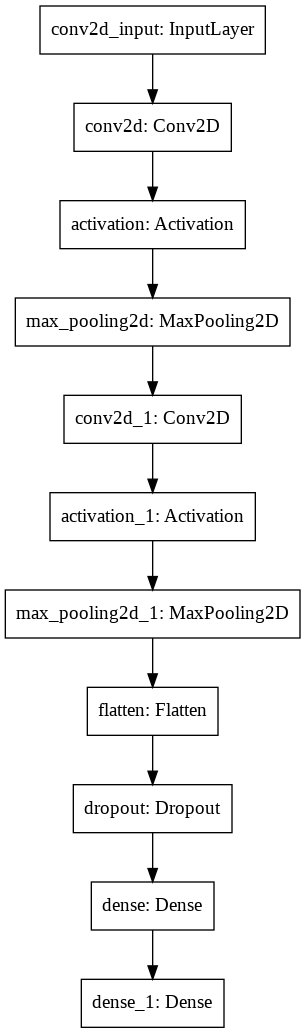

In [ ]:
# Plot the model
from keras.utils.vis_utils import plot_model
plot_model(model,to_file='face_mask_detection_architecture.png')

In [ ]:
from tensorflow.keras.optimizers import Adam

epochs = 50

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.001),
              metrics = ['accuracy'])

fitted_model = model.fit(
    train_X,
    train_y,
    epochs = epochs,
    validation_split = 0.25)


Epoch 1/50
50/50 [==============================] - 4s 61ms/step - loss: 2.0759e-04 - accuracy: 1.0000 - val_loss: 0.5670 - val_accuracy: 0.9604
Epoch 2/50
50/50 [==============================] - 3s 55ms/step - loss: 2.8907e-05 - accuracy: 1.0000 - val_loss: 0.5746 - val_accuracy: 0.9604
Epoch 3/50
50/50 [==============================] - 3s 55ms/step - loss: 0.0217 - accuracy: 0.9962 - val_loss: 0.6337 - val_accuracy: 0.9434
Epoch 4/50
50/50 [==============================] - 3s 55ms/step - loss: 0.0018 - accuracy: 0.9994 - val_loss: 0.5522 - val_accuracy: 0.9528
Epoch 5/50
50/50 [==============================] - 3s 55ms/step - loss: 1.5292e-04 - accuracy: 1.0000 - val_loss: 0.6458 - val_accuracy: 0.9509
Epoch 6/50
50/50 [==============================] - 3s 55ms/step - loss: 1.8121e-05 - accuracy: 1.0000 - val_loss: 0.5354 - val_accuracy: 0.9491
Epoch 7/50
50/50 [==============================] - 3s 55ms/step - loss: 7.9788e-06 - accuracy: 1.0000 - val_loss: 0.5541 - val_accuracy: 

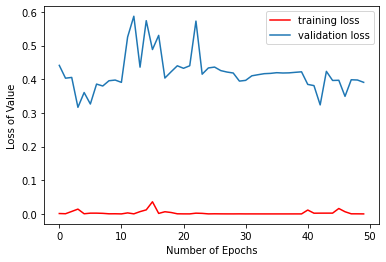

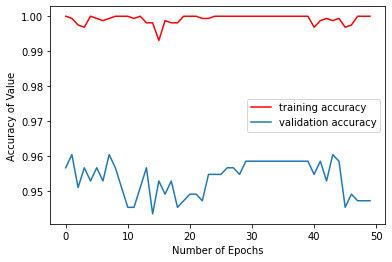

In [ ]:
from matplotlib import pyplot as plt
# Plot Training and Validation Loss
plt.plot(fitted_model.history['loss'],'r',label='training loss')
plt.plot(fitted_model.history['val_loss'],label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss of Value')
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.plot(fitted_model.history['accuracy'],'r',label='training accuracy')
plt.plot(fitted_model.history['val_accuracy'],label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy of Value')
plt.legend()
plt.show()